In [49]:
#installation
!pip install matplotlib numpy
!pip install opencv-python

In [50]:
#importing
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [51]:
def Process_image(input_path, output_path):

  #reading the reference and convert it to gray
  ref = cv2.imread('./ref.jpg')
  ref_g = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)

  #Define a bounding box in reference
  h, w = ref.shape[:2]
  box_pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

  #finding keypoints and describtors in reference
  sift = cv2.SIFT_create(nfeatures=5000)
  ref_keypoints, ref_descriptors = sift.detectAndCompute(ref_g, None)


  # defining Flann algorithm
  FLANN_INDEX_KDTREE = 1
  index_params = dict(algorithm=1, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)



  for f in Path(input_path).iterdir():

      #reading the image
      img = cv2.imread(input_path+'/'+f.name)
      gray_i = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


      #finding keypoints and describtors in the image
      img_keypoints, img_descriptors = sift.detectAndCompute(gray_i, None)

      #getting the matches using flann
      matches = flann.knnMatch(ref_descriptors, img_descriptors, k=2)

      # Filter good matches using Lowe's ratio test
      good_matches = []
      for m, n in matches:
          if m.distance < 0.5 * n.distance:
              good_matches.append(m)

      #checking if there enough matches
      if len(good_matches) > 10:

        # Extract matched keypoints' coordinates from reference and image
        ref_pts = np.float32([ref_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        img_pts = np.float32([img_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)


        # Calculate Homography
        H, _ = cv2.findHomography(ref_pts, img_pts, cv2.RANSAC)

        # Projecting the box onto the image using the homography
        projected_box_pts = cv2.perspectiveTransform(box_pts, H)

        # Inpaint the box with the background color
        mask = np.zeros_like(img, dtype=np.uint8)
        cv2.fillPoly(mask, [np.int32(projected_box_pts)], (255, 255, 255))  # Fill the box region
        result = cv2.inpaint(img, mask[:, :, 1], inpaintRadius=5, flags=cv2.INPAINT_TELEA)

        #writing the output
        cv2.imwrite(output_path+'/processed'+f.name, result)

      else:
        print('Invalid Picture '+f.name)


In [52]:
#test run
Process_image('./input', './output')

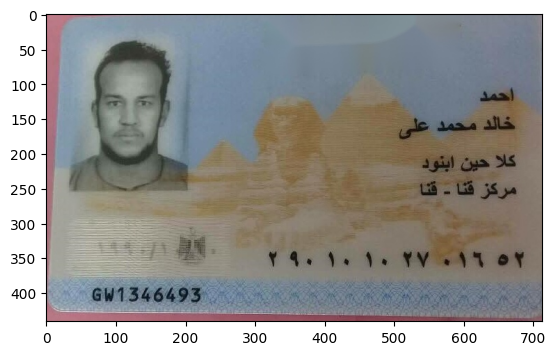

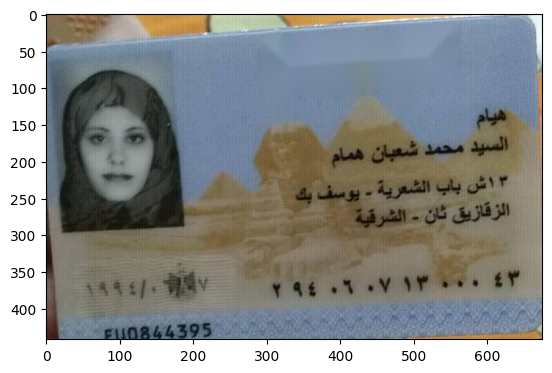

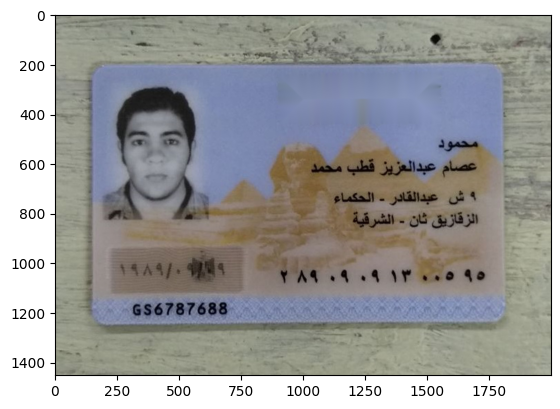

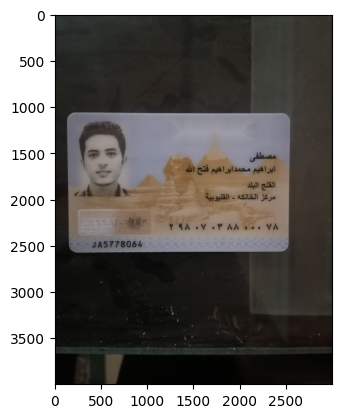

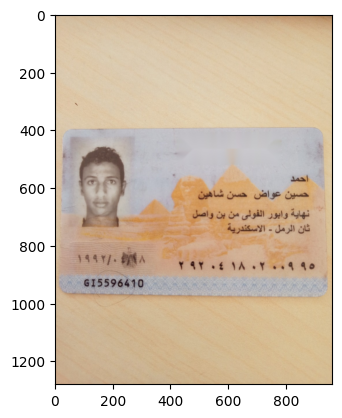

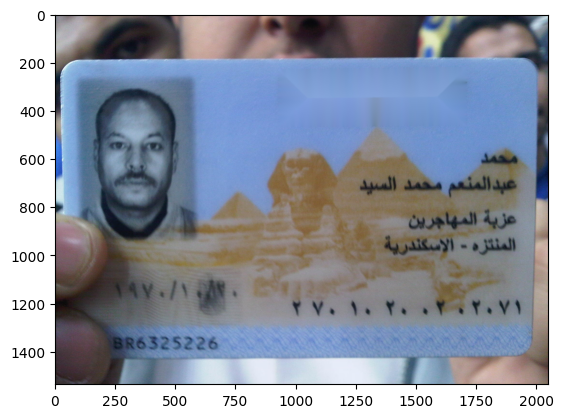

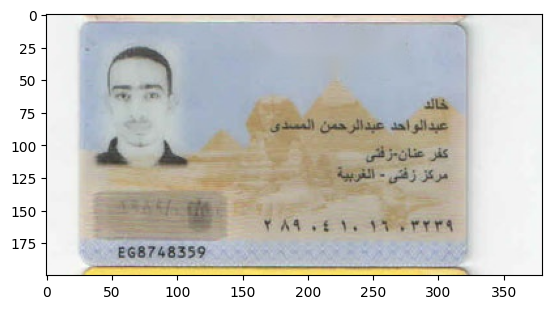

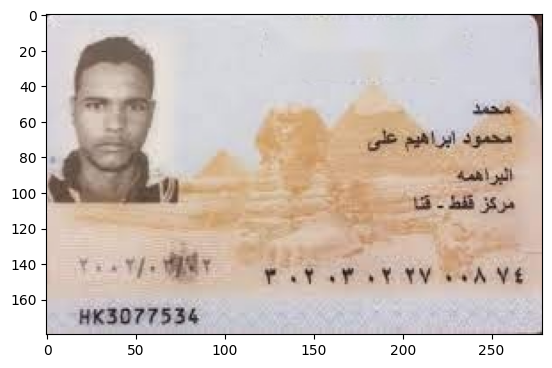

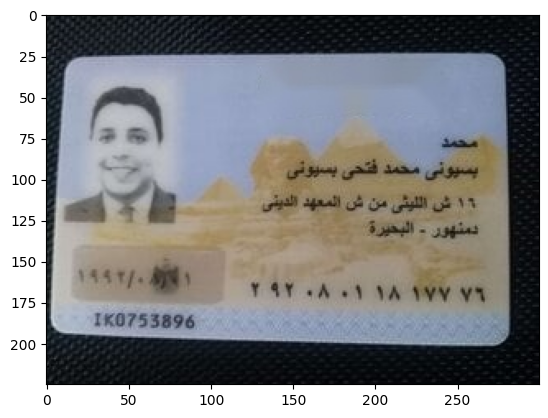

In [53]:
for img_path in  Path('output').iterdir():
        img = cv2.imread(str(img_path))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
